In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
sns.set(style="darkgrid")

In [2]:
df = pd.read_excel('DataSet.xlsx')
temp = df['Unnamed: 0'].dt.strftime("%Y%m%d")
ar = []
for i in temp:
  ar.append(int(i[:4]))
df['Unnamed: 0'] = ar
df.rename(columns={'Unnamed: 0': 'Временной период'}, inplace=True)
df.drop(['Unnamed: 12'], axis=1, inplace=True)
df.drop(['Unnamed: 13'], axis=1, inplace=True)
df.drop(['Unnamed: 14'], axis=1, inplace=True)
df.head()

,Временной период,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,2011,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669
1,2011,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680
2,2011,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673
3,2011,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519
4,2011,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779


Разделим данные на обучающуюся и тестовую выборки. С 01.2017 до 12.2017 у нас нет таргета, соответственно, данные для обучения будут все, где есть таргет, а данные для тестирования, где нет таргета (то есть после обучения мы предскажем на этих предикторах сам таргет).

In [3]:
import random

random.seed(10)

train = df.iloc[:72, :] #данные для обучения
test = df.iloc[72:, :].drop(['Прирост вкладов физических лиц в рублях (млн руб)'], axis=1) #тестовые данные


In [4]:
from sklearn.model_selection import train_test_split

np.random.seed(63)
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Прирост вкладов физических лиц в рублях (млн руб)'], axis=1),
                                                    train['Прирост вкладов физических лиц в рублях (млн руб)'], test_size=.15)


## Анализ датасета

Посмотрим сначала на значения целевой переменной:

<AxesSubplot:xlabel='Прирост вкладов физических лиц в рублях (млн руб)', ylabel='Density'>

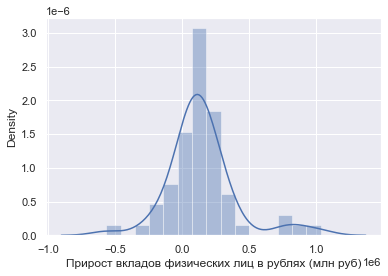

In [5]:
sns.distplot(y_train)

### Корреляция

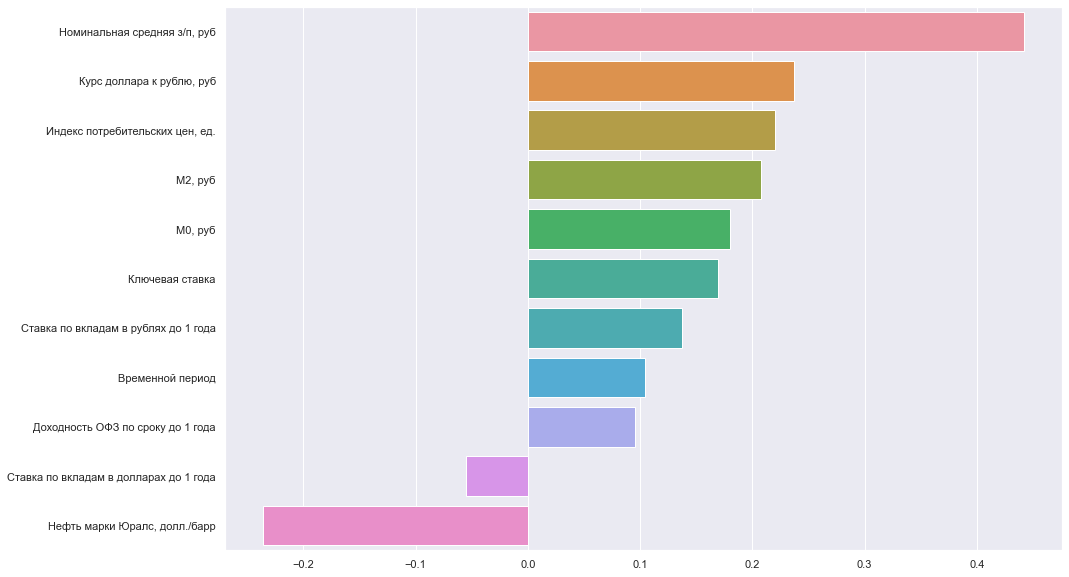

In [6]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Коэффициента корреляции Пирсона между признаками и целевой переменной показывает, что признаки нефть марки Юралс и ставка по вкладам в долларах имеют отрицательную корреляцию с целевой переменной. То есть при увеличении таргета данные признаки уменьшаются.

**Построим матрицу парной корреляции между признаками**

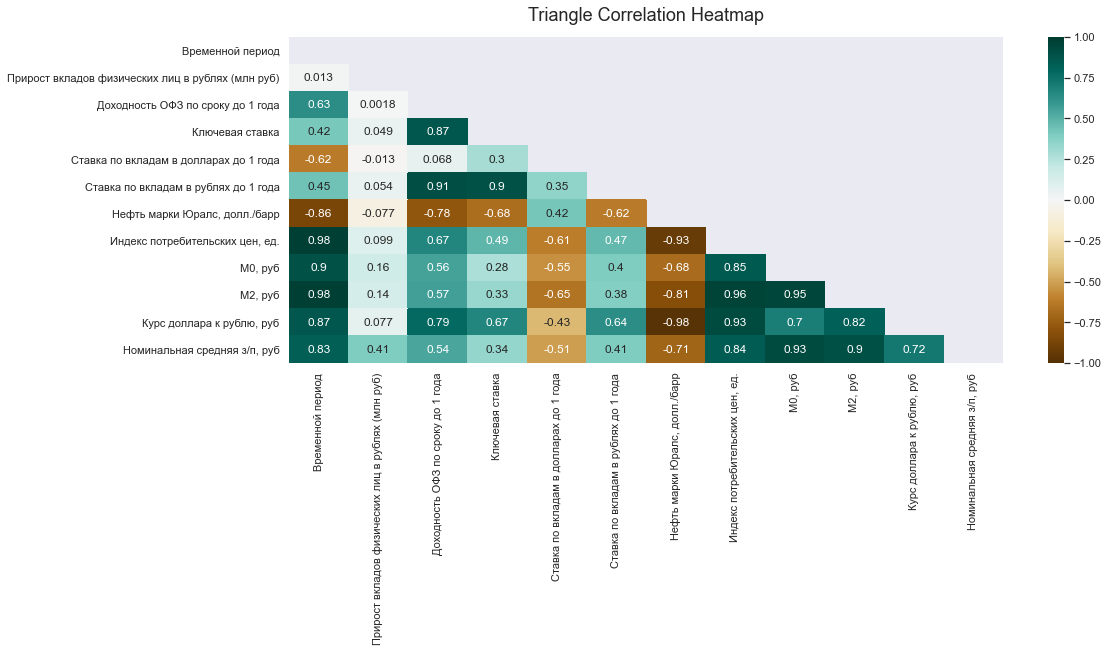

In [7]:
plt.figure(figsize=(16, 6)) 
 
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [8]:
train.corr().iloc[1:2,:]

,Временной период,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
Прирост вкладов физических лиц в рублях (млн руб),0.01316,1.0,0.001829,0.048946,-0.012823,0.053989,-0.077074,0.098694,0.160956,0.135086,0.077381,0.405291


Из корреляции выше видно, что переменные(предикторы): Доходность ОФЗ по сроку до 1 года, Ставка по вкладам в долларах до 1 года, Нефть марки Юралс, долл./барр, Курс доллара к рублю, руб и Ключевая ставка имеют очень слабую связь с нашим таргетом, поэтому работать с данными предикторами не имеет смысла.

In [9]:
train.drop(['Ставка по вкладам в долларах до 1 года'], axis=1, inplace=True)
train.drop(['Доходность ОФЗ по сроку до 1 года'], axis=1, inplace=True)
train.drop(['Нефть марки Юралс, долл./барр'], axis=1, inplace=True)
train.drop(['Ключевая ставка'], axis=1, inplace=True)
train.drop(['Курс доллара к рублю, руб'], axis=1, inplace=True)

train['Ставка по вкладам в рублях до\xa01\xa0года sin'] = np.sin(train['Ставка по вкладам в рублях до\xa01\xa0года'])
train['Индекс потребительских цен, ед. ^4'] = train['Индекс потребительских цен, ед.']**4
train['М0, руб^5'] = train['М0, руб']**5
train['М2, руб sin'] = np.sin(train['М2, руб'])
train['Прирост вкладов физических лиц в рублях (млн руб)^2'] = train['Прирост вкладов физических лиц в рублях (млн руб)']**3

train.drop(['Ставка по вкладам в рублях до\xa01\xa0года'], axis=1, inplace=True)
train.drop(['Индекс потребительских цен, ед.'], axis=1, inplace=True)
train.drop(['М0, руб'], axis=1, inplace=True)
train.drop(['М2, руб'], axis=1, inplace=True)


## Построение модели

In [10]:
from sklearn.model_selection import train_test_split

np.random.seed(63)
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Прирост вкладов физических лиц в рублях (млн руб)'], axis=1),
                                                    train['Прирост вкладов физических лиц в рублях (млн руб)'], test_size=.15)


In [11]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Mодель xgboost

In [12]:
import xgboost as xgb
from sklearn.metrics import r2_score
np.random.seed(0)
xg_reg = xgb.XGBRegressor(colsample_bytree=0.4,
                          gamma=0,                 
                          learning_rate=0.07,
                          max_depth=3,
                          min_child_weight=1.5,
                          n_estimators=10000,                                                                    
                          reg_alpha=0.75,
                          reg_lambda=0.45,
                          subsample=0.6,
                          seed=42, objective ='reg:squarederror')
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
RMSE = (np.square(np.subtract(y_test,y_pred)).mean())**.5

print('R^2:', r2_score(y_test, y_pred))
print('RMSE:', RMSE)

R^2: 0.8346042701243978
RMSE: 114969.5334006031


$R^2 = 0,834$ - коэфициент детерминации данной модели

$0,7 < R^2 < 0,99$ => данная модель имееет сильную прогностическую силу

## Прогноз таргета на 01.2017 – 12.2017

In [13]:
test.drop(['Ставка по вкладам в долларах до 1 года'], axis=1, inplace=True)
test.drop(['Доходность ОФЗ по сроку до 1 года'], axis=1, inplace=True)
test.drop(['Нефть марки Юралс, долл./барр'], axis=1, inplace=True)
test.drop(['Ключевая ставка'], axis=1, inplace=True)
test.drop(['Курс доллара к рублю, руб'], axis=1, inplace=True)

test['Ставка по вкладам в рублях до\xa01\xa0года sin'] = np.sin(test['Ставка по вкладам в рублях до\xa01\xa0года'])
test['Индекс потребительских цен, ед. ^4'] = test['Индекс потребительских цен, ед.']**4
test['М0, руб^5'] = test['М0, руб']**5
test['М2, руб sin'] = np.sin(test['М2, руб'])
test['Прирост вкладов физических лиц в рублях (млн руб)^2'] = test['М2, руб']**3

test.drop(['Ставка по вкладам в рублях до\xa01\xa0года'], axis=1, inplace=True)
test.drop(['Индекс потребительских цен, ед.'], axis=1, inplace=True)
test.drop(['М0, руб'], axis=1, inplace=True)
test.drop(['М2, руб'], axis=1, inplace=True)

In [14]:
test = sc_X.transform(test)

In [15]:
y_2017_prognoz = list(map(int, xg_reg.predict(test)))
y_2017_prognoz

[92096,
 173117,
 214694,
 185983,
 208653,
 274562,
 169359,
 139485,
 106201,
 192055,
 158124,
 225049]

In [16]:
dt = pd.read_excel('DataSet.xlsx')
dt.rename(columns={'Unnamed: 0': 'Временной период'}, inplace=True)
dt.drop(['Unnamed: 12'], axis=1, inplace=True)
dt.drop(['Unnamed: 13'], axis=1, inplace=True)
dt.drop(['Unnamed: 14'], axis=1, inplace=True)
dt['Прирост вкладов физических лиц в рублях (млн руб)'] = list(df['Прирост вкладов физических лиц в рублях (млн руб)'])[:72] + list(y_2017_prognoz)
dt.tail(12)

,Временной период,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
72,2017-01-01,92096.0,8.416190,10.00,0.79,6.50,54.89,166.434720,8.628900e+06,38016.800000,59.96,34422
73,2017-02-01,173117.0,8.830526,10.00,0.77,6.30,55.49,166.800870,8.711600e+06,38475.200000,58.39,35497
74,2017-03-01,214694.0,8.987727,9.75,0.80,5.91,51.97,167.017720,8.697700e+06,38555.200000,58.10,37899
75,2017-04-01,185983.0,8.655263,9.75,0.52,6.25,53.06,167.568870,8.936600e+06,38663.800000,56.43,39225
76,2017-05-01,208653.0,8.319500,9.25,0.76,6.10,50.87,168.188880,8.907000e+06,39222.900000,57.17,39679
77,2017-06-01,274562.0,8.039048,9.00,0.71,5.70,46.89,169.214830,9.066500e+06,39623.100000,57.82,41454
78,2017-07-01,169359.0,8.074286,9.00,0.66,6.07,48.50,169.333280,9.174300e+06,39275.900000,59.67,38073
79,2017-08-01,139485.0,7.882174,9.00,0.73,6.07,52.00,168.418880,9.194600e+06,39419.300000,59.65,37099
80,2017-09-01,106201.0,7.648095,8.50,0.66,5.31,57.00,168.166250,9.225200e+06,39571.000000,57.73,38047
81,2017-10-01,192055.0,7.503636,8.25,0.61,5.67,57.50,168.502590,9.246600e+06,39565.982237,57.71,38333


### График фактических и прогнозных значений таргета:

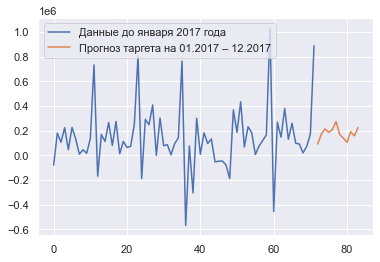

In [17]:
x1 = [i for i in range(72)]
plt.plot(x1, list(df['Прирост вкладов физических лиц в рублях (млн руб)'])[:72], label = 'Данные до января 2017 года')
x2 = [ i for i in range(72, 72+ len(y_2017_prognoz))]
plt.plot(x2, y_2017_prognoz, label = 'Прогноз таргета на 01.2017 – 12.2017')
plt.legend()
plt.show()

Запишем данные по прогнозу в таблицу DataSet_predicted.xlsx:

In [18]:
#dt.to_excel('DataSet_predicted.xlsx')

## Построение модели в статистическом пакете Gretl

В статистическом пакете Gretl было проверено несколько моделей: включающая все признаки, включающая все признаки и временной ряд и модель со значимыми признаками.

Модель с включенными в нее всеми признаками и временным рядом имеет более высокую точность прогнозов (более высокий R ^2), чем другие модели. Ниже представлены ее характеристики:

<img src="Характеристики модели.png">

$R^2 = 0,664$ - коэфициент детерминации данной модели

$0,5 < R^2 < 0,69$ => данная модель имееет среднюю прогностическую силу, близкую к сильной

## Интерпретация весов в линейной регрессии 

Ниже указаны доверительные интервалы оценок коэффициентов регрессии. С вероятностью 0,9 каждый из коэффициентов попадет в указанный интервал.

<img src="ДИ коэффициентов.png">

$y=b_0+b_1x_1+b_2x_2+...+b_9x_9+b_{10}x_{10}$, 

где $b_1 - b_{10}$ - веса линейной регрессии $v_2 - v_{11}$ из таблицы выше

### **Признаки, имеющие положительные линейные связи с таргетом:**

- Ставка по вкладам в долларах до 1 года - v4
- Индекс потребительских цен, ед. - v7 
- Курс доллара к рублю, руб - v10
- Номинальная средняя з/п, руб - v11

Для этих признаков при увеличении их значений будет наблюдаться прирост вкладов физических лиц в рублях (млн руб), что согласуется с экономической логикой данной зависимости.

### **Признаки, имеющие отрицательные линейные связи с таргетом:**

- Доходность ОФЗ по сроку до 1 года - v2
- Ключевая ставка - v3


Для этих признаков при увеличении их значений будет наблюдаться уменьшение вкладов физических лиц в рублях (млн руб), что согласуется с экономической логикой данной зависимости.

### **Признаки, слабо отличные от 0:**
- Нефть марки Юралс, долл./барр - v6 
- М0, руб - v8 
- М2, руб - v9 
- Ставка по вкладам в рублях до 1 года - v5

Для данных признаков в этой модели сложно сказать, какое именно влияние они оказывают на таргет.

### Здесь указаны прогнозные значения прироста вкладов физических лиц в рублях (млн руб):

<img src="Прогноз таргета.png">

### График фактических и прогнозных значений таргета:

<img src="График.png">